In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [11]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Tanh()  # Output values between -1 and 1 (similar to input normalized range)
        )

    def forward(self, x):
        # Flatten the image into a vector
        x = x.view(x.size(0), -1)
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 28, 28)
        return decoded

autoencoder = Autoencoder().to(device)

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [14]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()


        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}')


Epoch [1/10], Loss: 0.1798
Epoch [2/10], Loss: 0.0882
Epoch [3/10], Loss: 0.0728
Epoch [4/10], Loss: 0.0649
Epoch [5/10], Loss: 0.0599
Epoch [6/10], Loss: 0.0560
Epoch [7/10], Loss: 0.0530
Epoch [8/10], Loss: 0.0502
Epoch [9/10], Loss: 0.0479
Epoch [10/10], Loss: 0.0457


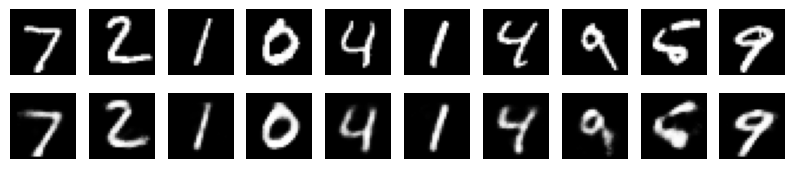

In [15]:
def visualize_reconstruction(model, loader):
    model.eval()
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)

            inputs = inputs.cpu()
            outputs = outputs.cpu()

            fig, axes = plt.subplots(2, 10, figsize=(10, 2))

            for i in range(10):
                axes[0, i].imshow(inputs[i].view(28, 28), cmap='gray')
                axes[0, i].axis('off')

            for i in range(10):
                axes[1, i].imshow(outputs[i].view(28, 28), cmap='gray')
                axes[1, i].axis('off')

            plt.show()
            break


visualize_reconstruction(autoencoder, testloader)


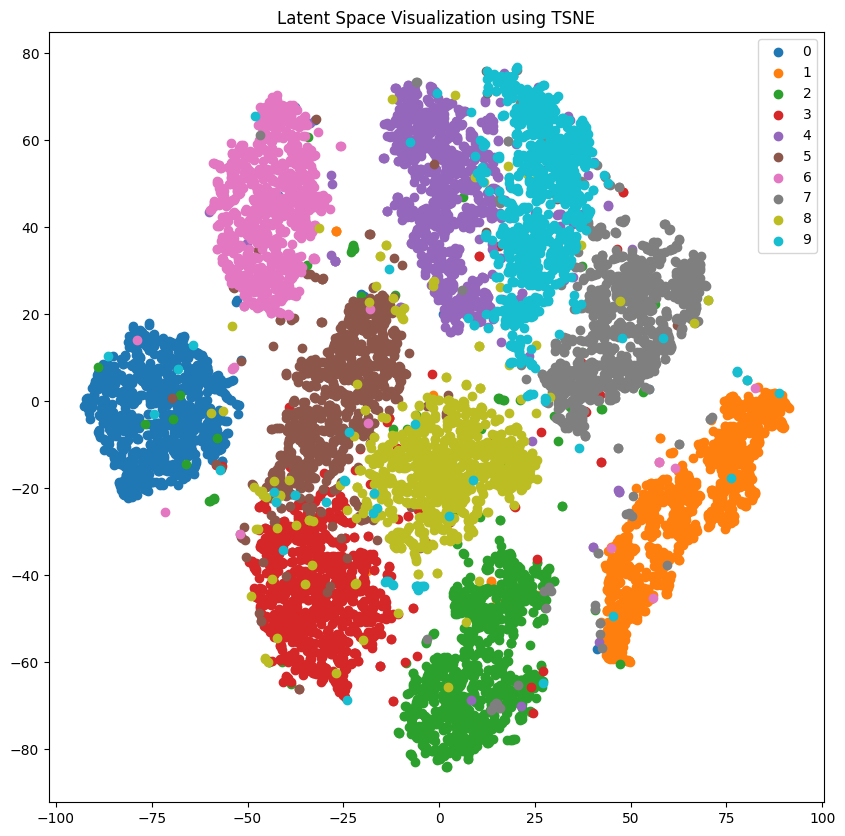

In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_latent_space(model, loader, method='tsne'):
    model.eval()
    latent_vectors = []
    labels_list = []

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)
            encoded = model.encoder(inputs.view(inputs.size(0), -1)).cpu()

            latent_vectors.append(encoded)
            labels_list.append(labels)

    latent_vectors = torch.cat(latent_vectors).numpy()
    labels_list = torch.cat(labels_list).numpy()

    if method == 'tsne':
        latent_2d = TSNE(n_components=2).fit_transform(latent_vectors)
    elif method == 'pca':
        latent_2d = PCA(n_components=2).fit_transform(latent_vectors)

    plt.figure(figsize=(10, 10))
    for i in range(10):
        idxs = labels_list == i
        plt.scatter(latent_2d[idxs, 0], latent_2d[idxs, 1], label=str(i))

    plt.legend()
    plt.title(f'Latent Space Visualization using {method.upper()}')
    plt.show()

visualize_latent_space(autoencoder, testloader, method='tsne')
